In [185]:
import glob
import os 
import densmap as dm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [186]:
# Exploration parameters
a = 0.8
n = 16
ca = 0.250

In [187]:
workdir = 'WorkdirRoughMeniscus/'
file_root = 'flow_'

In [188]:
# Input and output files
a_tag = str(a).replace('.','').ljust(2,'0')
n_tag = str(n).rjust(2,'0')
c_tag = str(10*ca).replace('.','').ljust(3,'0')
file_tag = 'N'+n_tag+'A'+a_tag+'C'+c_tag
folder_name = workdir+file_tag+'/'

In [189]:
Lx = 82.80000
Lz = 28.00000
Lx4 = Lx/4
waven  = 2*np.pi*n/Lx4
height = a/waven
phi_0  = 0
h_0    = 3.0
fun_sub = lambda x : height * np.sin(waven*x+phi_0) + h_0

In [190]:
# Automagically finding the index of the first and last file
dat_file_list = sorted([os.path.basename(x) for x in glob.glob(folder_name+'*.dat')])

### TEST ###
assert len(dat_file_list) > 0, "Empty directory!"

print(min([os.stat(x).st_size for x in glob.glob(folder_name+'*.dat')]))
assert min([os.stat(x).st_size for x in glob.glob(folder_name+'*.dat')]) > 0, "Corrupted output!"
n_init = int(dat_file_list[0][5:10].lstrip("0"))
n_fin = int(dat_file_list[-1][5:10].lstrip("0"))

886928


In [191]:
# Creating the meshgrid
density_array = dm.read_density_file(folder_name+'/'+file_root+'{:05d}'.format(n_init)+'.dat', bin='y')
Nx = density_array.shape[0]
Nz = density_array.shape[1]
hx = Lx/Nx
hz = Lz/Nz
x = hx*np.arange(0.0,Nx,1.0, dtype=float)+0.5*hx
z = hz*np.arange(0.0,Nz,1.0, dtype=float)+0.5*hz
X, Z = np.meshgrid(x, z, sparse=False, indexing='ij')

In [192]:
z_min = 5
z_max = 15
z_ref = 10

In [193]:
# INITIALIZATION
xc = np.sum(np.multiply(density_array[:,int(z_ref//hz)+1],x))/np.sum(density_array[:,int(z_ref//hz)+1])
dxc = 0.5*Lx-xc
density_array = np.roll(density_array, shift=int(dxc//hx), axis=0)
left_int, right_int = dm.detect_interface_loc(density_array, hx, hz, z_min, z_max, wall='l')

(-1.3877787807814457e-17, 82.79999999999998, -1.3877787807814457e-17, 28.0)

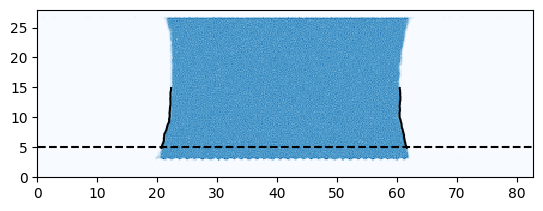

In [194]:
%matplotlib inline
plt.pcolormesh(X, Z, density_array, cmap=cm.Blues, vmax=1000)
plt.plot([x[0],x[-1]],[z_min,z_min],'k--')
plt.plot(left_int[0],left_int[1],'k-')
plt.plot(right_int[0],right_int[1],'k-')
plt.axis('scaled')

In [195]:
dt = 12.5
delta_th = 2.0
t = []
xcom = []
lcl = []
rcl = []

Obtainig frame 50
21.66550744845744 | 44.20542319137747 | 64.27762726565693
Obtainig frame 100
19.53648445287157 | 44.7956158425316 | 64.16561060615417
Obtainig frame 150
19.996074707775712 | 47.239734461200236 | 66.60904956761674
Obtainig frame 200
18.437812087256777 | 48.965812203717796 | 69.32058187145253
Obtainig frame 250
18.349958325740168 | 51.07060123561375 | 71.89341187358805
Obtainig frame 300
18.656712885630512 | 52.474102233189235 | 72.48395623640492
Obtainig frame 350
15.707961541173498 | 54.20885587719216 | 72.84058883813869
Obtainig frame 400
14.050662258627266 | 55.108160762961816 | 73.84631558614565
Obtainig frame 450
13.55478927563295 | 55.80694302812397 | 74.65389763516035
Obtainig frame 500
11.023587603772897 | 56.98284765529499 | 76.14396720611607
Obtainig frame 550
9.165725424337626 | 58.358552086329055 | 77.8484225264656


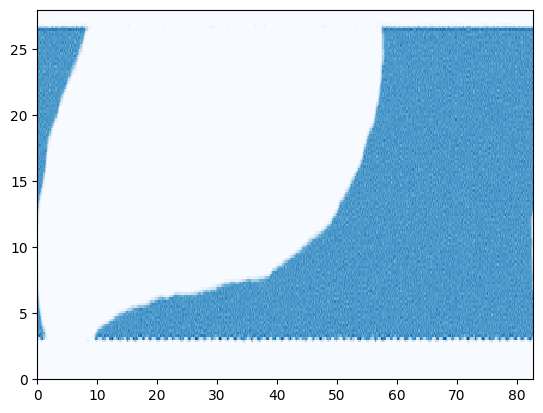

In [196]:
%matplotlib inline
n_dump = 50
for idx in range(n_init, n_fin):
    if idx%n_dump==0 :
        print("Obtainig frame "+str(idx))
        
    ### TEST ###
    try:
        density_array = dm.read_density_file(folder_name+'/'+file_root+'{:05d}'.format(idx)+'.dat', bin='y')
    except ValueError as e:
        print ('! Corrupted output !')
    
    density_array = np.roll(density_array, shift=int(dxc//hx), axis=0)
    xc = np.sum(np.multiply(density_array[:,int(z_ref//hz)+1],x))/np.sum(density_array[:,int(z_ref//hz)+1])
    dxc = 0.5*Lx-xc
    # density_array = np.roll(density_array, shift=int(dxc//hx), axis=0)
    left_int, right_int = dm.detect_interface_loc(density_array, hx, hz, z_min, z_max, wall='l')
    if left_int[0][0]>right_int[0][0] :
        break
    if idx%n_dump==0 :
        print(left_int[0][0],'|',xc,'|',right_int[0][0])
    t.append((1e-3)*idx*dt)
    xcom.append(xc)
    lcl.append(left_int[0][0])
    rcl.append(right_int[0][0])
plt.pcolormesh(X, Z, density_array, cmap=cm.Blues, vmax=1000)

Text(0, 0.5, '$\\Delta_{ls}x_{cl}$ [nm]')

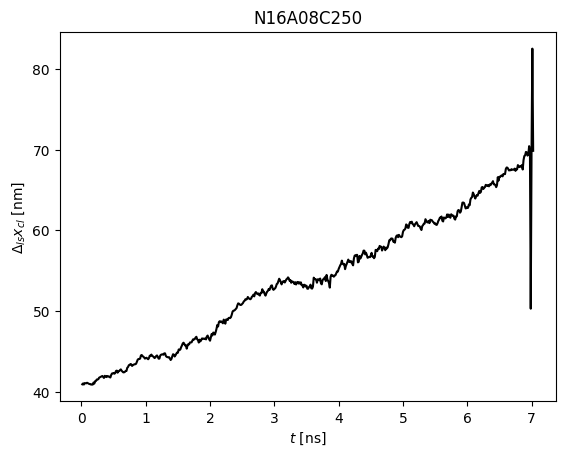

In [197]:
%matplotlib inline
lcl = np.array(lcl)
rcl = np.array(rcl)
dcl = rcl-lcl
t = np.array(t)
# plt.plot(t,lcl,'b-')
# plt.plot(t,rcl,'r-')
plt.title(file_tag)
plt.plot(t,dcl,'k-')
plt.xlabel(r"$t$ [ns]")
plt.ylabel(r"$\Delta_{ls}x_{cl}$ [nm]")

In [90]:
# Saving
np.savez(workdir+file_tag+'.npz', t, dcl)